One path to take when having multiple classifications is to split them up. That is, for each class we create one circuit that is specifically optimized to classify that class.
After seeing the promising results of the XOR circuit, we can try to replicate the same using IRIS but creating 3 different data maps: one for each class.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [2]:
#code to normalize weights to a range of -1 and 1
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

In [3]:
def fit_and_score(circuit_classifier, features, targets):
    plt.rcParams["figure.figsize"] = (12, 6)

    start_time = time.time()
    # fit classifier to data
    circuit_classifier.fit(features, targets)
    runtime = time.time() - start_time

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    score =  circuit_classifier.score(features, targets)
    print('Score: ' + str(score))
    return score, runtime

In [4]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    model_weights.append(weights)

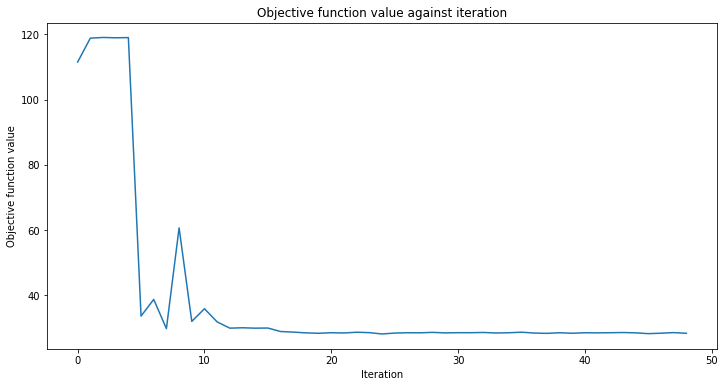

Score: 0.8933333333333333


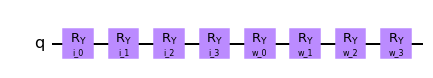

In [29]:
# parity maps bitstrings to 0 or 1
output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
def parity(x):
    return '{:b}'.format(x).count('1') % output_shape



dataset = load_iris()
data = dataset['data']
targets = np.array(dataset['target'])

quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator'), shots=1024)

normalized_features = np.array(normalize_data(data))

#split up the classes into 3 different arrays, one for each
targets_x = np.array([0 if a > 0 else 1 for a in targets])
targets_y = np.array([0 if a != 1 else 1 for a in targets])
targets_z = np.array([0 if a < 2 else 1 for a in targets])

feature_map = QuantumCircuit(1)
ansatz = QuantumCircuit(1)
for i in range(len(normalized_features[1])):
    feature_map.ry(Parameter('i_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i)),0)


qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))

circuit_qnn = CircuitQNN(circuit=qc, 
                         input_params=feature_map.parameters,
                         weight_params=ansatz.parameters,
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

# construct classifier
circuit_classifier = NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                             optimizer=COBYLA(),
                                             callback=callback_graph)



# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
model_weights = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets_x)
complexity = qc.decompose().width() * qc.decompose().depth()
display(qc.decompose().draw('mpl'))

#stats.append([runtime, score, complexity])

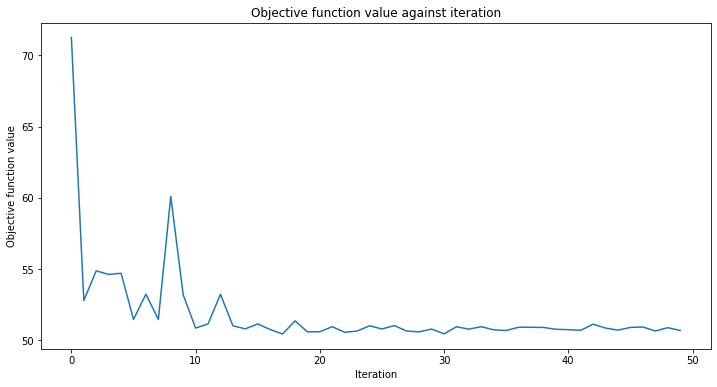

Score: 0.7333333333333333


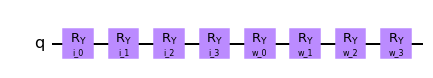

In [25]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
model_weights = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets_y)
complexity = qc.decompose().width() * qc.decompose().depth()
display(qc.decompose().draw('mpl'))

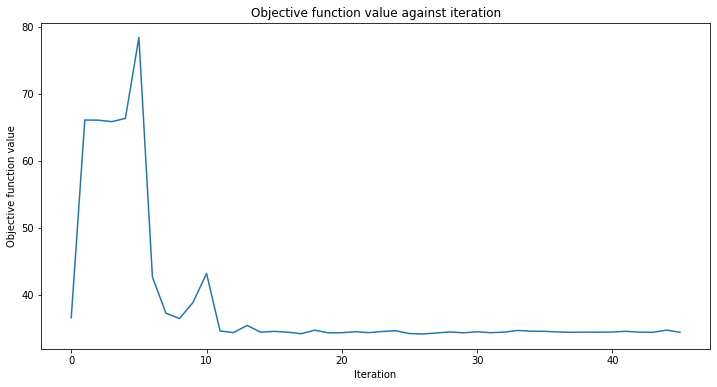

Score: 0.8733333333333333


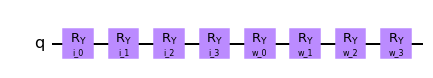

In [27]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
model_weights = []
score, runtime = fit_and_score(circuit_classifier, normalized_features, targets_z)
complexity = qc.decompose().width() * qc.decompose().depth()
display(qc.decompose().draw('mpl'))

As we can see we receive "acceptable" accuracy with blazing fast training times. The circuits in themselfs are relative simple too - it remains to be seen if doing multi-lane circuits for each class can improve the classification.